<a href="https://colab.research.google.com/github/SanyaMathur0411/Generative-AI/blob/main/Latent_space_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 26.4M/26.4M [01:11<00:00, 370kB/s] 
100%|██████████| 29.5k/29.5k [00:00<00:00, 75.1kB/s]
100%|██████████| 4.42M/4.42M [00:16<00:00, 263kB/s] 
100%|██████████| 5.15k/5.15k [00:00<00:00, 27.4kB/s]


Training VAE with latent_dim=10, learning_rate=0.01
Epoch 1: Train Loss = 268.4786, Val Loss = 254.7041
Epoch 2: Train Loss = 249.5312, Val Loss = 249.6955
Training VAE with latent_dim=10, learning_rate=0.001
Epoch 1: Train Loss = 279.5950, Val Loss = 257.0842
Epoch 2: Train Loss = 251.8957, Val Loss = 251.2303
Training VAE with latent_dim=10, learning_rate=0.0001
Epoch 1: Train Loss = 355.2348, Val Loss = 300.0386
Epoch 2: Train Loss = 284.2444, Val Loss = 275.0905
Training VAE with latent_dim=20, learning_rate=0.01
Epoch 1: Train Loss = 271.2480, Val Loss = 255.0414
Epoch 2: Train Loss = 251.1815, Val Loss = 252.0269
Training VAE with latent_dim=20, learning_rate=0.001
Epoch 1: Train Loss = 283.8138, Val Loss = 261.9787
Epoch 2: Train Loss = 255.5083, Val Loss = 253.5726
Training VAE with latent_dim=20, learning_rate=0.0001
Epoch 1: Train Loss = 357.0781, Val Loss = 301.9425
Epoch 2: Train Loss = 287.4954, Val Loss = 280.0828
Training VAE with latent_dim=50, learning_rate=0.01
Epoch 

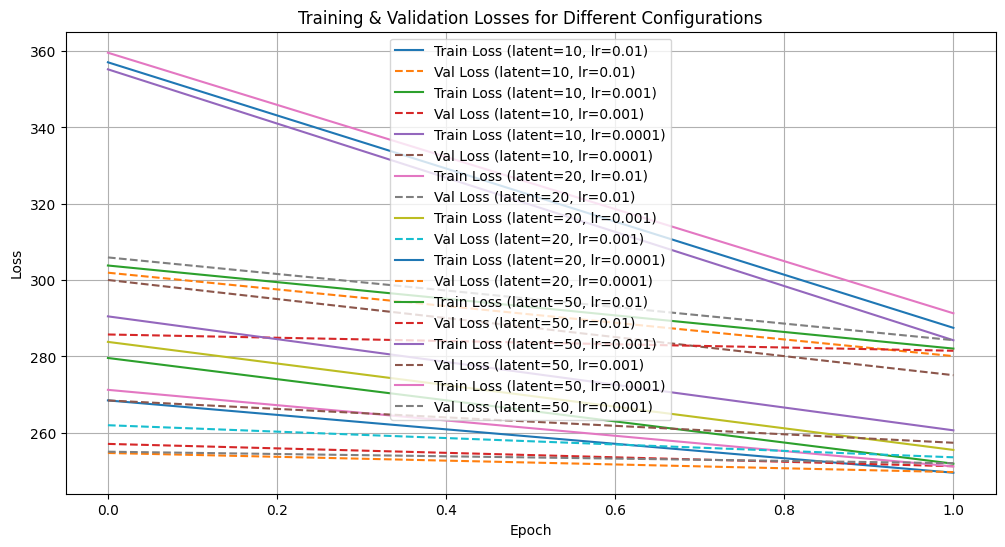

Best configuration: Latent=10, LR=0.01


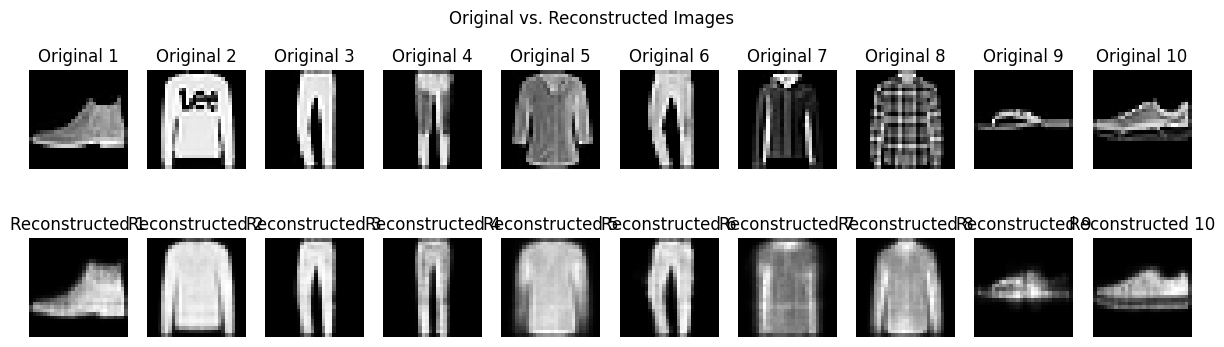

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Hyperparameter Experimentation
latent_dims = [10, 20, 50]  # Different latent space sizes
learning_rates = [1e-2, 1e-3, 1e-4]  # Different learning rates
batch_size = 128
epochs = 2

# Data Preparation
transform = transforms.ToTensor()
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# VAE Model Class
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(28*28, 400)
        self.fc21 = nn.Linear(400, latent_dim)  # Mean
        self.fc22 = nn.Linear(400, latent_dim)  # Log variance
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 28*28)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss Function
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training and Evaluation Function
def train_vae(latent_dim, learning_rate):
    model = VAE(latent_dim)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0
        for data, _ in train_loader:
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        train_losses.append(train_loss / len(train_loader.dataset))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, _ in test_loader:
                recon_batch, mu, logvar = model(data)
                val_loss += loss_function(recon_batch, data, mu, logvar).item()
        val_losses.append(val_loss / len(test_loader.dataset))

        print(f'Epoch {epoch}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}')

    return model, train_losses, val_losses

# Run Experiments
results = {}
for latent_dim in latent_dims:
    for lr in learning_rates:
        print(f'Training VAE with latent_dim={latent_dim}, learning_rate={lr}')
        model, train_losses, val_losses = train_vae(latent_dim, lr)
        results[(latent_dim, lr)] = (model, train_losses, val_losses)

# Compare Losses
plt.figure(figsize=(12, 6))
for (latent_dim, lr), (_, train_losses, val_losses) in results.items():
    plt.plot(train_losses, label=f'Train Loss (latent={latent_dim}, lr={lr})')
    plt.plot(val_losses, linestyle='dashed', label=f'Val Loss (latent={latent_dim}, lr={lr})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Losses for Different Configurations')
plt.grid(True)
plt.show()

# Side-by-Side Reconstruction
best_config = min(results, key=lambda x: results[x][2][-1])  # Choose best model by val loss
best_model = results[best_config][0]
print(f'Best configuration: Latent={best_config[0]}, LR={best_config[1]}')

best_model.eval()
with torch.no_grad():
    test_data, _ = next(iter(test_loader))
    recon_data, _, _ = best_model(test_data)
    fig, axes = plt.subplots(2, 10, figsize=(15, 4))
    for i in range(10):
        axes[0, i].imshow(test_data[i].view(28, 28), cmap='gray')
        axes[0, i].set_title(f'Original {i+1}')
        axes[0, i].axis('off')
        axes[1, i].imshow(recon_data[i].view(28, 28), cmap='gray')
        axes[1, i].set_title(f'Reconstructed {i+1}')
        axes[1, i].axis('off')
    plt.suptitle('Original vs. Reconstructed Images')
    plt.show()


Latent space visualization is a technique used to understand how a Variational Autoencoder (VAE) organizes data in its learned lower-dimensional representation. By reducing the latent space to two dimensions using techniques like t-SNE (t-Distributed Stochastic Neighbor Embedding), we can visually analyze how the model clusters similar data points.
How Latent Space Visualization Works
Step 1: Encode Input Data into Latent Space. Then, using the reparameterization trick, we sample from the latent space:
Step 2: Collect Latent Vectors and Labels
Each input image in the test set is passed through the encoder to obtain its latent representation. The corresponding class labels are stored to color the visualization.
Step 3: Apply t-SNE for Dimensionality Reduction. The latent vectors z are high-dimensional (e.g., 10, 20, or 50 dimensions).
t-SNE reduces them to 2D space while preserving relationships between points.
Step 4: Scatter Plot the Latent Space
Each point in the scatter plot represents a latent vector
The color of each point corresponds to the class label (e.g., different clothing categories in FashionMNIST).
If the model has learned useful representations, distinct categories will appear as separate clusters.


Training VAE with latent_dim=10, learning_rate=0.01
Epoch 1: Train Loss = 269.6080, Val Loss = 253.3756
Epoch 2: Train Loss = 249.9162, Val Loss = 249.9373
Training VAE with latent_dim=10, learning_rate=0.001
Epoch 1: Train Loss = 280.2371, Val Loss = 257.6917
Epoch 2: Train Loss = 252.2398, Val Loss = 251.3975
Training VAE with latent_dim=10, learning_rate=0.0001
Epoch 1: Train Loss = 355.7634, Val Loss = 298.6579
Epoch 2: Train Loss = 282.2617, Val Loss = 274.0065
Training VAE with latent_dim=20, learning_rate=0.01
Epoch 1: Train Loss = 282.3737, Val Loss = 263.8606
Epoch 2: Train Loss = 258.1772, Val Loss = 258.1668
Training VAE with latent_dim=20, learning_rate=0.001
Epoch 1: Train Loss = 285.3879, Val Loss = 262.5585
Epoch 2: Train Loss = 256.1831, Val Loss = 254.8605
Training VAE with latent_dim=20, learning_rate=0.0001
Epoch 1: Train Loss = 359.2526, Val Loss = 303.2037
Epoch 2: Train Loss = 287.9876, Val Loss = 280.5419
Training VAE with latent_dim=50, learning_rate=0.01
Epoch 

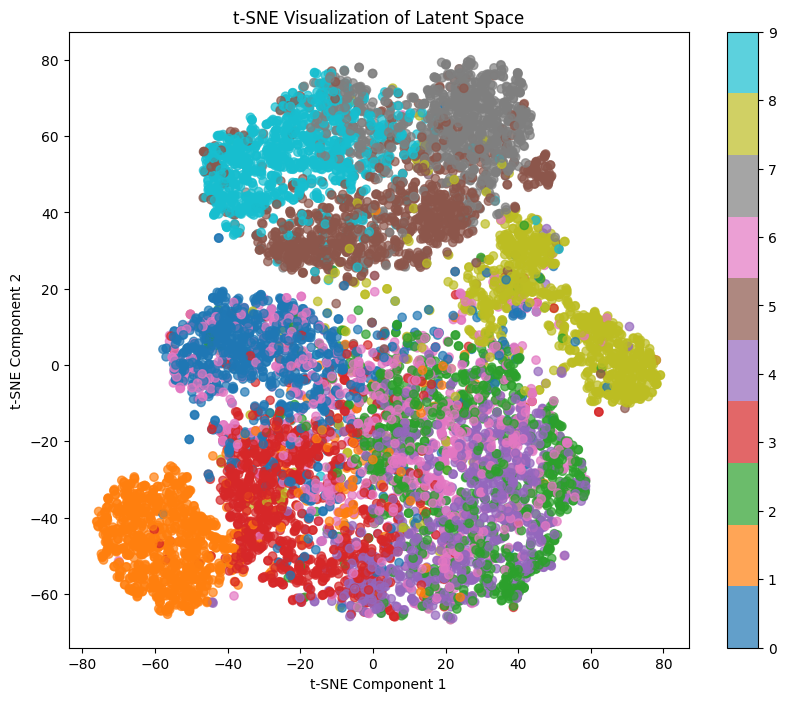

In [ ]:
# Latent Space Visualization
def visualize_latent_space(model, test_loader):
    z_list, labels = [], []
    model.eval()
    with torch.no_grad():
        for data, label in test_loader:
            mu, logvar = model.encode(data.view(-1, 28*28))
            z = model.reparameterize(mu, logvar)
            z_list.append(z)
            labels.append(label)

    z_all = torch.cat(z_list).numpy()
    labels_all = torch.cat(labels).numpy()

    tsne = TSNE(n_components=2)
    z_embedded = tsne.fit_transform(z_all)

    plt.figure(figsize=(10, 8))
    plt.scatter(z_embedded[:, 0], z_embedded[:, 1], c=labels_all, cmap='tab10', alpha=0.7)
    plt.colorbar()
    plt.title('t-SNE Visualization of Latent Space')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()
results = {}
for latent_dim in latent_dims:
    for lr in learning_rates:
        print(f'Training VAE with latent_dim={latent_dim}, learning_rate={lr}')
        model, train_losses, val_losses = train_vae(latent_dim, lr)
        results[(latent_dim, lr)] = (model, train_losses, val_losses)

# Select Best Model and Visualize Latent Space
best_config = min(results, key=lambda x: results[x][2][-1])  # Choose best model by val loss
best_model = results[best_config][0]
print(f'Best configuration: Latent={best_config[0]}, LR={best_config[1]}')
visualize_latent_space(best_model, test_loader)


In [ ]:
!pip uninstall torchmetrics torch-fidelity -y
!pip install torchmetrics[image] torch-fidelity


Found existing installation: torchmetrics 1.6.1
Uninstalling torchmetrics-1.6.1:
  Successfully uninstalled torchmetrics-1.6.1
  Using cached torchmetrics-1.6.1-py3-none-any.whl.metadata (21 kB)
Using cached torchmetrics-1.6.1-py3-none-any.whl (927 kB)



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
pip install torchmetrics[image]

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


1. Data Preprocessing
Converts images to tensors using transforms.ToTensor().
Uses DataLoader to load the dataset in mini-batches for efficient training.

2. Loss Function
The VAE loss function consists of:
Reconstruction Loss (Binary Cross Entropy - BCE): Measures how well the reconstructed images match the original ones.
Kullback-Leibler Divergence (KLD): Regularizes the latent space by ensuring it follows a normal distribution.

3. Training the VAE
Multiple VAE models are trained with different latent dimensions and learning rates.
The model is trained using the Adam optimizer.
Batch gradient descent updates the weights using backpropagation.

4. Selecting the Best Model
The model with the lowest validation loss is selected as the best.
Hyperparameters like latent dimension and learning rate are tuned to optimize performance.

5. Latent Space Exploration
Interpolation: Generates intermediate samples by blending two latent vectors.
Manipulation: Adjusts specific latent dimensions to observe their effect on image generation.

6. New Sample Generation
Samples are drawn from the learned latent space and decoded into images.
Helps in visualizing how well the VAE captures the underlying data distribution.

7. Performance Evaluation (FID Score)
Frechet Inception Distance (FID) is used to measure the quality of generated images.
FID compares the distribution of real and generated images, with lower scores indicating better performance.

8. Latent Space Visualization
t-SNE (t-Distributed Stochastic Neighbor Embedding) is used to reduce high-dimensional latent vectors to 2D.
Helps visualize how well the model clusters different clothing categories in the latent space.


Training VAE with latent_dim=10, learning_rate=0.01
Epoch 1: Train Loss = 268.2768, Val Loss = 252.6778
Epoch 2: Train Loss = 249.5519, Val Loss = 249.5795
Training VAE with latent_dim=10, learning_rate=0.001
Epoch 1: Train Loss = 281.7372, Val Loss = 258.1410
Epoch 2: Train Loss = 252.4579, Val Loss = 251.2049
Training VAE with latent_dim=10, learning_rate=0.0001
Epoch 1: Train Loss = 355.5500, Val Loss = 298.6061
Epoch 2: Train Loss = 283.0850, Val Loss = 275.3980
Training VAE with latent_dim=20, learning_rate=0.01
Epoch 1: Train Loss = 276.2026, Val Loss = 258.6722
Epoch 2: Train Loss = 254.1176, Val Loss = 254.2123
Training VAE with latent_dim=20, learning_rate=0.001
Epoch 1: Train Loss = 284.9888, Val Loss = 262.8657
Epoch 2: Train Loss = 256.3860, Val Loss = 254.3366
Training VAE with latent_dim=20, learning_rate=0.0001
Epoch 1: Train Loss = 359.6594, Val Loss = 302.1061
Epoch 2: Train Loss = 287.3502, Val Loss = 279.9672
Training VAE with latent_dim=50, learning_rate=0.01
Epoch 

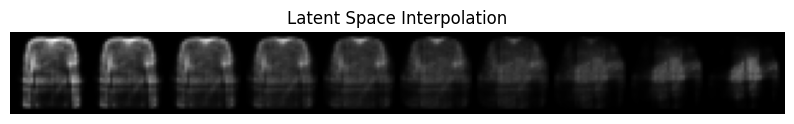

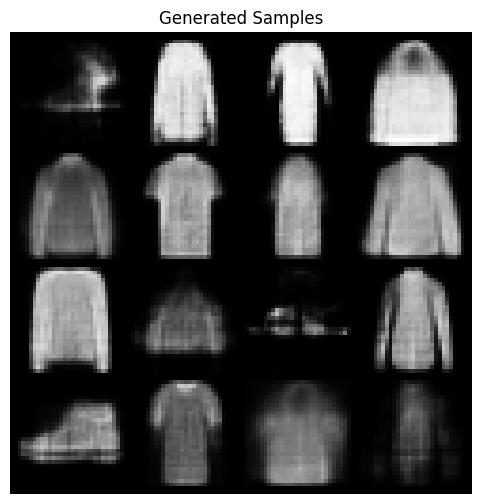

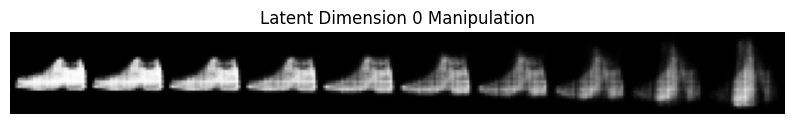

FID Score: 170.4250


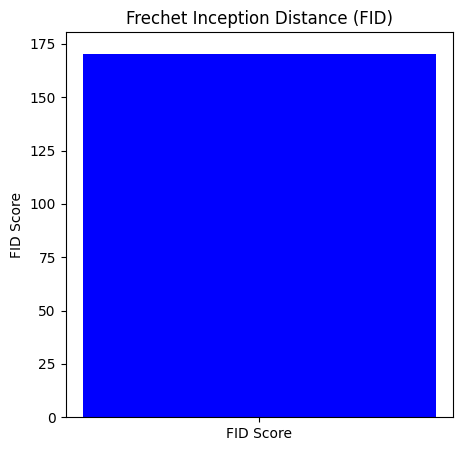

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from scipy.stats import norm
from torchmetrics.image.fid import FrechetInceptionDistance



# Hyperparameter Experimentation
latent_dims = [10, 20, 50]  # Different latent space sizes
learning_rates = [1e-2, 1e-3, 1e-4]  # Different learning rates
batch_size = 128
epochs = 2

# Data Preparation
transform = transforms.ToTensor()
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# VAE Model Class
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(28*28, 400)
        self.fc21 = nn.Linear(400, latent_dim)  # Mean
        self.fc22 = nn.Linear(400, latent_dim)  # Log variance
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 28*28)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss Function
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training and Evaluation Function
def train_vae(latent_dim, learning_rate):
    model = VAE(latent_dim)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0
        for data, _ in train_loader:
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        train_losses.append(train_loss / len(train_loader.dataset))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, _ in test_loader:
                recon_batch, mu, logvar = model(data)
                val_loss += loss_function(recon_batch, data, mu, logvar).item()
        val_losses.append(val_loss / len(test_loader.dataset))

        print(f'Epoch {epoch}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}')

    return model, train_losses, val_losses


# Run Experiments
results = {}  # Initialize results dictionary here
for latent_dim in latent_dims:
    for lr in learning_rates:
        print(f'Training VAE with latent_dim={latent_dim}, learning_rate={lr}')
        model, train_losses, val_losses = train_vae(latent_dim, lr)
        results[(latent_dim, lr)] = (model, train_losses, val_losses)

# ... (rest of your code)
# 1. Latent Space Exploration (Sampling and Interpolation)
def interpolate_latent_space(model, device, num_samples=10):
    z1 = torch.randn(1, model.fc3.in_features, device=device)
    z2 = torch.randn(1, model.fc3.in_features, device=device)

    z_interpolated = torch.stack([z1 * (1 - alpha) + z2 * alpha for alpha in np.linspace(0, 1, num_samples)], dim=0)
    model.eval()
    with torch.no_grad():
        samples = model.decode(z_interpolated).cpu()

    grid_img = make_grid(samples.view(-1, 1, 28, 28), nrow=num_samples, normalize=True)
    plt.figure(figsize=(10, 2))
    plt.imshow(grid_img.permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.title('Latent Space Interpolation')
    plt.show()

# 2. New Sample Generation
def generate_new_samples(model, device, num_samples=16):
    z = torch.randn(num_samples, model.fc3.in_features, device=device)
    model.eval()
    with torch.no_grad():
        samples = model.decode(z).cpu()

    grid_img = make_grid(samples.view(-1, 1, 28, 28), nrow=4, normalize=True)
    plt.figure(figsize=(6, 6))
    plt.imshow(grid_img.permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.title('Generated Samples')
    plt.show()

# 3. Manipulating the Latent Space
def manipulate_latent_space(model, device, base_sample, dim, num_steps=10):
    base_latent, _ = model.encode(base_sample.view(-1, 28*28).to(device))
    manipulations = torch.linspace(-2, 2, num_steps).to(device)

    z_manipulated = torch.stack([base_latent + m * torch.eye(base_latent.shape[1], device=device)[dim] for m in manipulations])
    model.eval()
    with torch.no_grad():
        samples = model.decode(z_manipulated).cpu()

    grid_img = make_grid(samples.view(-1, 1, 28, 28), nrow=num_steps, normalize=True)
    plt.figure(figsize=(10, 2))
    plt.imshow(grid_img.permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.title(f'Latent Dimension {dim} Manipulation')
    plt.show()

# 4. Performance Metrics (FID Calculation and Plot)
def compute_fid(model, test_loader, device, max_batches=10):
    fid = FrechetInceptionDistance(feature=64).to(device)
    model.eval()

    with torch.no_grad():
        for i, (real_batch, _) in enumerate(test_loader):
            if i >= max_batches:  # Limit the number of batches to reduce memory usage
                break

            real_batch = real_batch.to(device)
            real_batch = (real_batch * 255).clamp(0, 255).to(torch.uint8)  # Convert to uint8

            # Convert grayscale (1 channel) to RGB (3 channels)
            real_batch = real_batch.repeat(1, 3, 1, 1)

            z = torch.randn(real_batch.size(0), model.fc3.in_features, device=device)
            fake_batch = model.decode(z)
            fake_batch = (fake_batch * 255).clamp(0, 255).to(torch.uint8)

            # Convert fake images to 3 channels
            fake_batch = fake_batch.repeat(1, 3, 1, 1)

            fid.update(real_batch, real=True)
            fid.update(fake_batch, real=False)

    # Compute FID score
    fid_score = fid.compute().item()
    print(f'FID Score: {fid_score:.4f}')

    # Visualization
    plt.figure(figsize=(5, 5))
    plt.bar(['FID Score'], [fid_score], color='blue')
    plt.ylim(0, max(50, fid_score + 10))
    plt.title('Frechet Inception Distance (FID)')
    plt.ylabel('FID Score')
    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure best_config is properly defined
best_config = min(results, key=lambda x: results[x][2][-1])  # Select best model based on validation loss
best_model = results[best_config][0]  # Get the corresponding model
best_model.to(device)

# Call the functions
interpolate_latent_space(best_model, device)
generate_new_samples(best_model, device)

# Get a sample image from the test set
sample_image, _ = next(iter(test_loader))
manipulate_latent_space(best_model, device, sample_image[0], dim=0)

# Compute FID score
compute_fid(best_model, test_loader, device)

